In [202]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [203]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [204]:
def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    return cm
    
def accuracy(y_true, y_pred):
    """Oblicza dokładność klasyfikacji."""
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred, average='macro'):
    """Oblicza precyzję. Obsługuje micro/macro averaging."""
    cm = confusion_matrix(y_true, y_pred, num_classes=len(np.unique(y_true)))
    
    if average == 'macro':
        precisions = []
        for i in range(cm.shape[0]):
            TP = cm[i, i]
            FP = np.sum(cm[:, i]) - TP
            precisions.append(TP / (TP + FP) if (TP + FP) != 0 else 0)
        return np.mean(precisions)
    
    elif average == 'micro':
        TP = np.sum(np.diagonal(cm))
        FP = np.sum(cm) - TP
        return TP / (TP + FP)

def recall(y_true, y_pred, average='macro'):
    """Oblicza recall. Obsługuje micro/macro averaging."""
    cm = confusion_matrix(y_true, y_pred, num_classes=len(np.unique(y_true)))
    
    if average == 'macro':
        recalls = []
        for i in range(cm.shape[0]):
            TP = cm[i, i]
            FN = np.sum(cm[i, :]) - TP
            recalls.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
        return np.mean(recalls)
    
    elif average == 'micro':
        TP = np.sum(np.diagonal(cm))
        FN = np.sum(cm) - TP
        return TP / (TP + FN)

def f1_score(y_true, y_pred, average='macro'):
    """Oblicza F1-score. Obsługuje micro/macro averaging."""
    prec = precision(y_true, y_pred, average)
    rec = recall(y_true, y_pred, average)
    
    if average == 'macro':
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0
    
    elif average == 'micro':
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

In [205]:
class KNNClassifier:
    def __init__(self, k=3, metric='euclidean',  p=2):
        self.k = k
        self.p = p
        self.metric = metric
        self.X_train = np.empty((0, 0))
        self.y_train = np.array([])  
        
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)

    def predict(self, X_test):
        def euclidean_distance(x1, x2):
            return np.sqrt(np.sum((x1 - x2) ** 2))
        def minkowski_distance(x1, x2, p):
            return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)
        
        predictions = []
        for test_point in X_test.values:
            if self.metric == 'minkowski':
                distances = np.array([minkowski_distance(test_point, train_point, self.p) for train_point in self.X_train])
            else:
                distances = np.array([euclidean_distance(test_point, train_point) for train_point in self.X_train])
            nearest_neighbors_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_neighbors_indices]
            most_common_label = np.bincount(nearest_labels).argmax()
            predictions.append(most_common_label)
        
        return np.array(predictions)

def optimize_k(X_train, y_train, X_val, y_val):
    k_values = range(1, 21)
    accuracies = []

    for k in k_values:
        knn = KNNClassifier(k=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        accuracy_val = accuracy(y_val, y_pred)
        accuracies.append(accuracy_val)

    plt.plot(k_values, [1 - acc for acc in accuracies], marker='o')
    plt.title('Błąd klasyfikacji w zależności od k')
    plt.xlabel('k')
    plt.xticks(range(1, 21))
    plt.ylabel('Błąd (1 - accuracy)')
    plt.grid(True)
    plt.show()

    best_k = k_values[np.argmax(accuracies)]
    return best_k
    
def optimize_p(X_train, y_train, X_val, y_val):
    p_values = [1, 1.5, 2, 3, 4]
    accuracies = []

    for p in p_values:
        knn = KNNClassifier(k=3, metric='minkowski', p=p)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        accuracy_val = accuracy(y_val, y_pred)
        accuracies.append(accuracy_val)

    plt.plot(p_values, [1 - acc for acc in accuracies], marker='o')
    plt.title('Błąd klasyfikacji w zależności od p')
    plt.xlabel('p')
    plt.ylabel('Błąd (1 - accuracy)')
    plt.grid(True)
    plt.show()
    best_p = p_values[np.argmax(accuracies)]
    return best_p

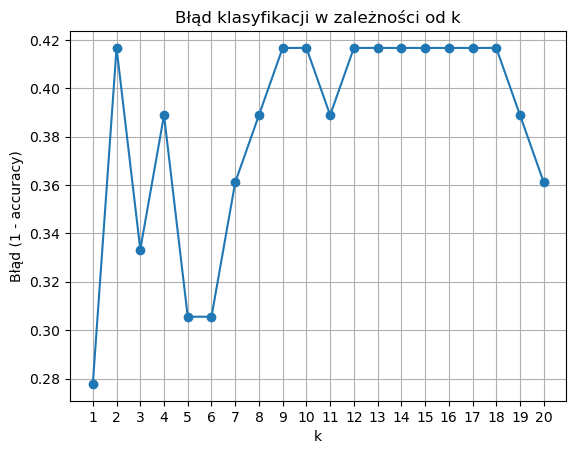

Najlepsza wartość k: 1


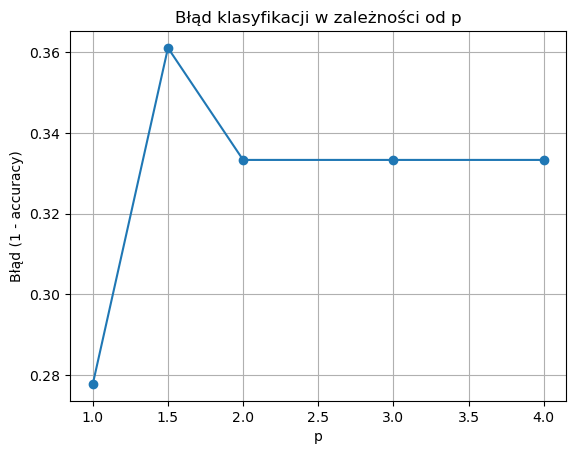

Najlepsza wartość p: 1
Dokładność modelu z najlepszymi hiperparametrami na zbiorze testowym: 0.8333333333333334
Dokładność modelu dla k=3 i p=2 na zbiorze testowym: 0.6666666666666666
Confusion Matrix:
 [[12  1  1]
 [ 2 13  0]
 [ 1  1  5]]
Macro Precision: 0.8333333333333334
Macro Recall: 0.8126984126984128
Macro F1-score: 0.8228865316618451
Micro Precision: 0.8333333333333334
Micro Recall: 0.8333333333333334
Micro F1-score: 0.8333333333333334


In [206]:
best_k = optimize_k(X_train, y_train, X_val, y_val)
print(f"Najlepsza wartość k: {best_k}")

best_p = optimize_p(X_train, y_train, X_val, y_val)
print(f"Najlepsza wartość p: {best_p}")

#Testowanie modelu z najlepszymi hiperparametrami na zbiorze testowym
knn_best = KNNClassifier(k=best_k, metric='minkowski', p=best_p)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)
final_accuracy = accuracy(y_test, y_pred_best)
print(f"Dokładność modelu z najlepszymi hiperparametrami na zbiorze testowym: {final_accuracy}")

#Predykcja na zbiorze testowym dla k=3, p=2
knn_fixed_k = KNNClassifier(k=3)
knn_fixed_k.fit(X_train, y_train)
y_pred_fixed_k = knn_fixed_k.predict(X_test)
fixed_k_accuracy = accuracy(y_test, y_pred_fixed_k)
print(f"Dokładność modelu dla k=3 i p=2 na zbiorze testowym: {fixed_k_accuracy}")

#Obliczanie wyników metryk
cm = confusion_matrix(y_test, y_pred_best, num_classes=len(np.unique(y_test)))
print("Confusion Matrix:\n", cm)

prec_macro = precision(y_test, y_pred_best, average='macro')
print("Macro Precision:", prec_macro)

rec_macro = recall(y_test, y_pred_best, average='macro')
print("Macro Recall:", rec_macro)

f1_macro = f1_score(y_test, y_pred_best, average='macro')
print("Macro F1-score:", f1_macro)

prec_micro = precision(y_test, y_pred_best, average='micro')
print("Micro Precision:", prec_micro)

rec_micro = recall(y_test, y_pred_best, average='micro')
print("Micro Recall:", rec_micro)

f1_micro = f1_score(y_test, y_pred_best, average='micro')
print("Micro F1-score:", f1_micro)